In [21]:
import warnings

import numpy as np
import pandas as pd
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import flyvision
from flyvision.utils.activity_utils import LayerActivity
from flyvision_ans import DECODING_CELLS
import wandb
from conv_models import DecodingImagesCNN
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos, paths_to_labels, load_custom_sequences
from logs_to_wandb import hex_to_square_grid
from utils import plot_weber_fraction

warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)
torch.manual_seed(42)
batch_size = 64
last_good_frame = 2

TRAINING_DATA_DIR = "easy_videos"
TESTING_DATA_DIR = "easyval_videos"

debugging = True
debug_length = 20
wandb_ = True
wandb_images_every = 10

num_epochs = 1

channel_sizes = [16, 32, 64]
mult_size = 1
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .65

In [22]:
network_view = flyvision.NetworkView(flyvision.results_dir / "opticflow/000/0000")
network = network_view.init_network(chkpt="best_chkpt")
dt = 1 / 100
extent, kernel_size = 15, 13
receptors = flyvision.rendering.BoxEye(extent=extent, kernel_size=kernel_size)

all_videos = get_files_from_directory(TRAINING_DATA_DIR)
all_validation_videos = get_files_from_directory(TESTING_DATA_DIR)

In [23]:
def activation_vector_to_image(da):
    images = np.apply_along_axis(hex_to_square_grid, axis=1, arr=da.cpu().numpy())
    # TODO: think about how to treat the missings
    return np.nan_to_num(images)

def layer_activations_to_decoding_images(la, frame, decoding_cells):
    # only decoding activations
    da = [a[decoding_cells][0, -frame, :, :] for a in la]
    # decoded images
    return np.array([activation_vector_to_image(a) for a in da])

In [24]:
model = DecodingImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)
lr = .01
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [25]:
model.train()

iterations = debug_length if debugging else len(all_videos) // batch_size
# Start wandb run
if wandb_:
    wandb.init(project='la_classification')
    data_table = wandb.Table(columns=["Predictions", "True Labels"])

# Training loop
for epoch in range(num_epochs):
    already_selected = []
    running_loss = 0.0
    total_correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        batch_files, already_selected = select_random_videos(
            all_videos, batch_size, already_selected
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)
        
        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float).to(DEVICE)

        # Create the dataset and dataloader
        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs.to(DEVICE)
            batch_labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward pass
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
    
            # Backward pass and optimize
                loss.backward()
                optimizer.step()
    
                # Calculate the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                predictions = torch.sigmoid(outputs).squeeze() > 0.5
                total += batch_labels.size(0)
                total_correct += (predictions == batch_labels).sum().item()
                
                if wandb_:
                    predictions = torch.sigmoid(outputs).squeeze().detach().cpu()
                    batch_labels_cpu = batch_labels.detach().cpu()
                    for pred, label in zip(predictions, batch_labels_cpu):
                        data_table.add_data(pred.item(), label.item())

        # Log metrics to wandb
        if wandb_:
            wandb.log({
                'epoch': epoch,
                'loss': running_loss / total,
                'accuracy': total_correct / total,
            })
    wandb.log({"predictions_vs_labels": data_table})

    print(f'Epoch {epoch+1}, Loss: {running_loss / total}, Accuracy: {total_correct / total}')

100%|██████████| 20/20 [16:33<00:00, 49.69s/it]


Epoch 1, Loss: 0.7335503935813904, Accuracy: 0.5


In [26]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

validation_results = pd.DataFrame(columns=["Image", "Prediction", "True Label"])

with torch.no_grad():
    for i in tqdm(range(2)):
        batch_files, _ = select_random_videos(
            all_validation_videos, batch_size, already_selected=[]
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)
        
        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float).to(DEVICE)

        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            
            # Forward pass only to get logits/output
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            running_loss += loss.item() * inputs.size(0)
            predictions = torch.round(torch.sigmoid(outputs).squeeze()).cpu().numpy()
            correct = np.where(predictions == batch_labels.cpu().numpy(), 1, 0)
            total += batch_labels.size(0)
            total_correct += correct.sum().item()
            
            validation_results = pd.concat(
                [validation_results, pd.DataFrame({
                    "Image": batch_files,
                    "Prediction": predictions.squeeze().tolist(),
                    "True label": batch_labels.tolist(),
                    "Is correct": correct.tolist()
        })]
            )
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')

100%|██████████| 2/2 [01:39<00:00, 49.66s/it]


accuracy,█▇▄▂▂▃▂▁▁▁▁▁▁▁▂▁▁▂▂▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▃▂▄▄▂▅▆▅▅▇███▇▇▇▆▆▆
val_accuracy,▁
val_loss,▁
accuracy,0.5
epoch,0
loss,0.73355
val_accuracy,0.57031
val_loss,0.68416


Validation Loss: 0.6841578483581543, Validation Accuracy: 0.5703125


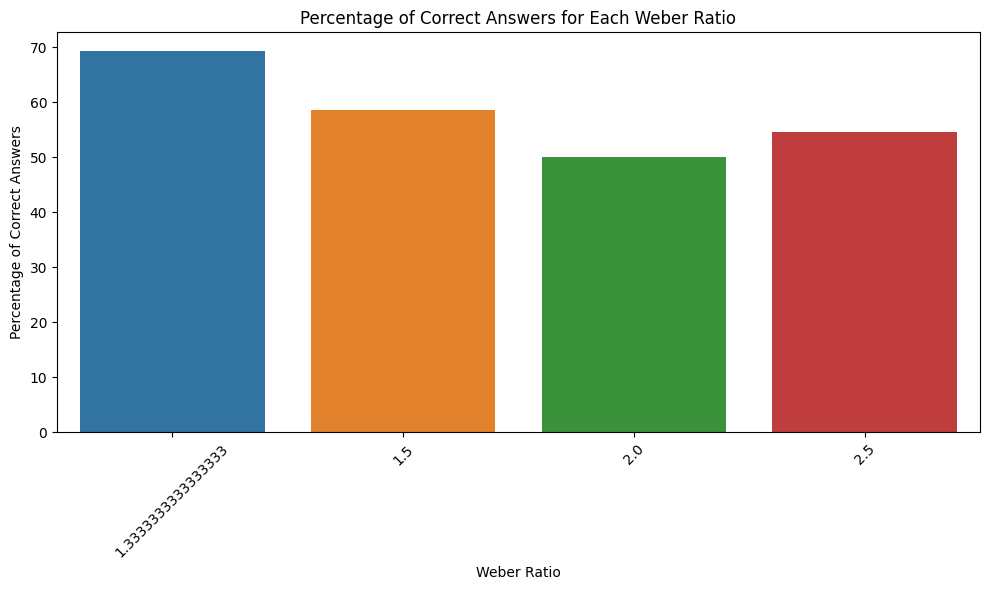

In [27]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    wandb.log({
        'val_loss': running_loss / total,
        'val_accuracy': total_correct / total,
        "validation_results": wandb.Table(dataframe=validation_results),
        "Weber Fraction Plot": wandb.Image(weber_plot)
    })
    wandb.finish()



In [29]:
total_correct

73

In [28]:
validation_results

,Image,Prediction,True Label,Correct Prediction,yellow,blue,weber_ratio
0,easyval_videos/yellow/img2_12_9_11_sequence.npy,1.0,1.0,1,12,9,1.333333
1,easyval_videos/blue/img_8_12_16_equalized_sequ...,1.0,0.0,0,8,12,1.500000
2,easyval_videos/blue/img_5_10_46_sequence.npy,1.0,0.0,0,5,10,2.000000
3,easyval_videos/blue/img2_6_8_0_sequence.npy,1.0,0.0,0,6,8,1.333333
4,easyval_videos/yellow/img2_12_6_2_sequence.npy,1.0,1.0,1,12,6,2.000000
...,...,...,...,...,...,...,...
59,easyval_videos/yellow/img_16_12_8_sequence.npy,1.0,1.0,1,16,12,1.333333
60,easyval_videos/yellow/img_8_6_32_sequence.npy,1.0,1.0,1,8,6,1.333333
61,easyval_videos/yellow/img2_6_4_14_equalized_se...,1.0,1.0,1,6,4,1.500000
62,easyval_videos/yellow/img_8_4_43_sequence.npy,1.0,1.0,1,8,4,2.000000


In [9]:
from pytorch_model_summary import summary

print(summary(DecodingImagesCNN(), torch.zeros((1, 34, 31, 31)), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1     [1, 34, 31, 31]           4,912           4,912
         BatchNorm2d-2     [1, 16, 31, 31]              32              32
             Dropout-3     [1, 16, 15, 15]               0               0
              Conv2d-4     [1, 16, 15, 15]           4,640           4,640
         BatchNorm2d-5     [1, 32, 15, 15]              64              64
              Conv2d-6       [1, 32, 7, 7]          18,496          18,496
         BatchNorm2d-7       [1, 64, 7, 7]             128             128
   AdaptiveAvgPool2d-8       [1, 64, 3, 3]               0               0
              Linear-9             [1, 64]              65              65
Total params: 28,337
Trainable params: 28,337
Non-trainable params: 0
---------------------------------------------------------------------------


In [12]:
predictions

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])